   ## Dimensionality Reduction and Analysis of Sea Surface Height over the Gulf of Mexico
   
   
   The goal of this project is the analysis of Sea Surface Height model data generated over the Gulf of Mexico, provided courtesy of Thierry Penduff, MEOM team, IGE Grenoble. More info on the data here:
  
   https://meom-group.github.io/projects/occiput/

   The data consists in simulations of 1/4° global ocean simulations over the period 1960-2015, using around 50 different initial conditions (Here only one member is given over a period of 20 years, but others can be obtained upon request). For each time date, the data is an image of around 70x80 pixels.
   
   The dataset is large and hard to analyse fully as is. Dimensionality reduction can be helpful for several tasks:
   - It allows to summarize the information in the data in a reduced number of variables
   - It can be used to compress the data, or to reduce the computation time for expensive tasks
   - It helps interpreting the data by providing "modes" that capture general patterns which are representative of the whole data behavior
   
   We will use two different dimension reduction techniques: Principal Component Analysis (PCA, a.k.a Empirical Orthogonal Functions, EOF) and autoencoders. We will discuss the differences between the two and their interest for dimension reduction.



# Import Packages

In [1]:
!pip install netCDF4

import numpy as np
from netCDF4 import Dataset
import matplotlib.image as mpimg
import os
import pickle

import torch

import random as rd
import matplotlib.pyplot as plt

# Import Data
The data is available on this Google Drive folder:
https://drive.google.com/file/d/1R9JQ0v-47ObaKtw1o9UOSrrmss9sWfTF/view?usp=sharing

One way to get it is to simply download it from there, possibly put it on your own drive and then upload it in your Colab session.

Alternatively, you can directly transfer the files from the folder to this session using the "gdown" command, as shown below:

In [3]:
!gdown 1R9JQ0v-47ObaKtw1o9UOSrrmss9sWfTF -O GOM025.GSL301_m0042_1d_dtrend.ncROI.pkl

Downloading...
From: https://drive.google.com/uc?id=1R9JQ0v-47ObaKtw1o9UOSrrmss9sWfTF
To: /content/GOM025.GSL301_m0042_1d_dtrend.ncROI.pkl
100% 151M/151M [00:01<00:00, 84.6MB/s]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.4 MB/s eta 0:00:00
.... reading file GOM025.GSL301_m0042_1d_dtrend.ncROI.pkl
0.5461295


Text(0, 0.5, 'ssh')

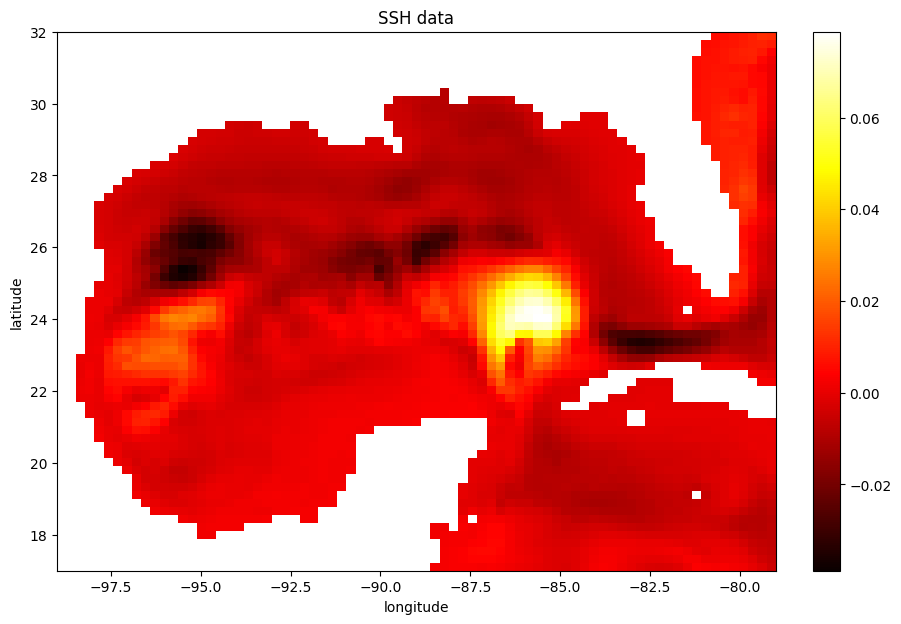

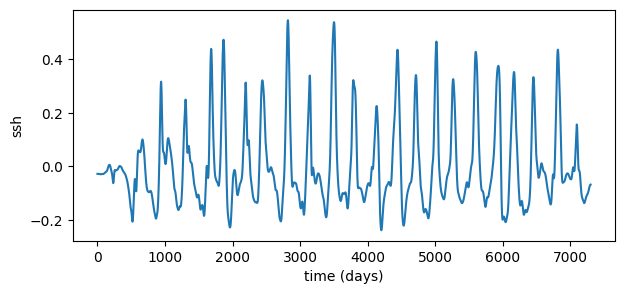

In [6]:


SelectedField = 'ssh'

plt.rcParams['figure.figsize'] = [12, 7]

latBounds = [17,32]
lonBounds = [-99,-79]

# test for reading a given member

filename = 'GOM025.GSL301_m0042_1d_dtrend.ncROI.pkl'

filehandler = open(filename, 'rb')
SelectedField = pickle.load(filehandler)
latBounds = pickle.load(filehandler)
lonBounds = pickle.load(filehandler)
indNoNaN = pickle.load(filehandler)
indlat = pickle.load(filehandler)
indlon = pickle.load(filehandler)

flagRemoveHF = pickle.load(filehandler)
flagRemoveMean = pickle.load(filehandler)
sigmaFilt = pickle.load(filehandler)

sshROI = pickle.load(filehandler)

print('.... reading file %s'%(filename))

imgplot = plt.imshow(sshROI[45,:,:],extent=(lonBounds[0],lonBounds[1],latBounds[0],latBounds[1]), origin = 'lower')
imgplot.set_cmap('hot')
plt.axis('image')
plt.title('SSH data')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(fraction=0.04, pad=0.04)


# plotting the time series at a given point

print(np.amax(sshROI[:,40,40]))

fig = plt.figure(figsize=(7,3))

plt.plot(sshROI[:,40,40])
plt.xlabel('time (days)')
plt.ylabel('ssh')

In [9]:
# Plotting the whole time series

# Importing ipywidgets for interactive plotting
from ipywidgets import *
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


def plt_ssh(t):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title(r"SSH data at t = {:.2f}".format(t),fontsize=15)
    ax.set_ylabel(r"SSH", fontsize=20)
    imgplot = plt.imshow(sshROI[t,:,:],extent=(lonBounds[0],lonBounds[1],latBounds[0],latBounds[1]),vmin = -.1, vmax = 0.1, origin = 'lower')
    imgplot.set_cmap('jet')
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.show()

# interactive plot u(x,y,t) for varying t
interact(plt_ssh, t=(0,2300,1))

interactive(children=(IntSlider(value=1150, description='t', max=2300), Output()), _dom_classes=('widget-inter…

<function __main__.plt_ssh(t)>

# First task: Dimension Reduction and data visualization

The goal of this task is to compute a reduced representation of the dataset, useful for visualization and summarization purposes.

This can be done by either a PCA (principal componenent analysis) or an autoencoder.

The data is a 3-way array $X \in \mathbb{R}^{T \times m \times n}$ where $T$ is the number of time steps, and $m$ and $n$ are the spatial dimensions of the image.


# Principal Component Analysis (PCA)

One first analysis techniques that can be performed for data understanding and visualisation is Principal Component Analysis (PCA), also called Empirical Orthogonal Functions (EOF). The goal is to identify a set of variables, called components, that are orthogonal to one another and best explain the dataset in a particular sense (i.e. the projection of the data on the subspace spanned by any number of these components in order maximizes the variance for projections on subspaces of this dimension). PCA applies to a dataset $\mathbf{X} \in \mathbb{R}^{P\times N}$, where $P$ is the number of variables, and $N$ is the number of samples. PCA finds orthogonal components $u_k \in \mathbb{R}^{P}, k = 1,...P$ and coefficients $a_{kn}$ such that
\begin{equation*}
\mathbf{x}_n = \sum_{k=1}^P a_{kn} \mathbf{u}_k
\end{equation*}
with $\mathbf{u}_k^T \mathbf{u}_l = 0$ for $k\neq l$, and $||\mathbf{u}_k|| = 1$.
The $\mathbf{u}_k$ form an orthonormal basis. So, PCA is a change of basis. The first two or three components can be used for data visualisation, since it is the most faithful representation of the data that we can get in a 2D or 3D linear subspace. For a complete reference on PCA, see the book by Christopher Bishop, *Pattern Recognition and Machine Learning*, chapter 12: https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/


The dataset can then be approximated by a weighted sum of the different components, for a given number of components $K$:

\begin{equation*}
\mathbf{x}_n \approx \sum_{k=1}^K a_{kn} \mathbf{u}_k
\end{equation*}

The easiest way to compute principal component analysis is to use the scikit-learn package (sklearn) for python. See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

The algorithm is based on the eigendecomposition of the covariance matrix of the dataset, whose eigenvectors are the principal components. The coefficients are obtained by orthoghonal projection of the data on the obtained basis. The eigenvalues give the variance associated to each component. Computing the percentage of total variance explained by $K$ components is a way to assess the quality of the approximation.

The question is, what do you want to consider as variables and what do you want to consider as samples in your dataset?

In [ ]:
import sklearn
from sklearn.decomposition import PCA



#  Autoencoder for nonlinear dimension reduction/unmixing

Another way to explain the data/reduce the dimensionality is to use deep autoencoders. They are used to find a reduced representation of the data with a small number of variables. The technique applies to data $\mathbf{X} \in \mathbb{R}^{P\times N}$, where $P$ is the number of input variables, and $N$ is the number of samples, just like PCA. The difference with PCA is that autoencoders are nonlinear! For an input $\mathbf{x} \in \mathbb{R}^{P}$, the quantity $\phi(\mathbf{x}) = \mathbf{z}\in \mathbb{R}^{K}$ is an encoded version of $\mathbf{x}$. The network is trained so that the decoded quantity $\mathbf{x}' = \psi(\mathbf{z}) ≈ \mathbf{x}$

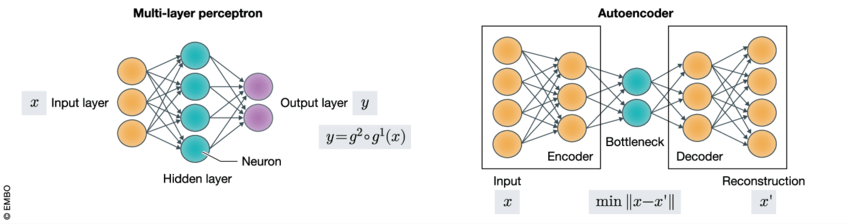


To build and train an autoencoder in pytorch, or pytorch-lightning, one needs first to build a dataset class for the data to be understood by pytorch, and a DataLoader class to be able to feed the model with batches of data.

It is always good practice to divide the dataset into at least two sets: a training set and a validation set (and possibly a test set).

Then, you can focus on creating the model, choosing a cost function to minimize, and training the model.


In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader


# Time series prediction

Another problem we propose to to tackle with this dataset is to build a NN (or another type of model) that can predict the future evolution of the time series.

Here, for NN based approaches, RNNs such as LSTM are a natural choice. But there can be many more approaches, based on DL or not, that can be tested.

Again, it is best to leave out the end of the time series as validation data to find out how good the model is for short or long term predictions.